Based on

https://github.com/ageron/handson-ml3/blob/main/17_autoencoders_gans_and_diffusion_models.ipynb

# Setup

This project requires Python 3.7 or above:

In [1]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

And TensorFlow ≥ 2.8:

In [3]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [4]:
import numpy as np

In [5]:
from tensorflow.keras.utils import plot_model

As we did in earlier chapters, let's define the default font sizes to make the figures prettier:

In [14]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

This chapter can be very slow without a GPU, so let's make sure there's one, or else issue a warning:

In [ ]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Convolutional Autoencoders

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

Let's load the fashion MNIST dataset, scale it, and split it into a training set, a validation set, and a test set:

In [20]:
# extra code – loads, scales, and splits the  MNIST dataset
mnist = tf.keras.datasets.mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

conv_encoder = tf.keras.Sequential([
    tf.keras.layers.Reshape([28, 28, 1]),
    tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 14 × 14 x 16
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 7 × 7 x 32
    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 3 × 3 x 64
    tf.keras.layers.Conv2D(30, 3, padding="same", activation="relu"),
    tf.keras.layers.GlobalAvgPool2D()  # output: 30
])
conv_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(3 * 3 * 16),
    tf.keras.layers.Reshape((3, 3, 16)),
    tf.keras.layers.Conv2DTranspose(32, 3, strides=2, activation="relu"),
    tf.keras.layers.Conv2DTranspose(16, 3, strides=2, padding="same",
                                    activation="relu"),
    tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding="same"),
    tf.keras.layers.Reshape([28, 28])
])
conv_ae = tf.keras.Sequential([conv_encoder, conv_decoder])

# extra code – compiles and fits the model
conv_ae.compile(loss="mse", optimizer="nadam")
history = conv_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

In [12]:
#conv_ae.save('/content/gdrive/MyDrive/DL_5783/Materials/Models/conv_ae.keras')
conv_ae = tf.keras.models.load_model('/content/gdrive/MyDrive/DL_5783/Materials/Models/conv_ae.keras')

## Visualizing the Reconstructions

In [13]:
def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

1/1 [==============================] - 0s 146ms/step


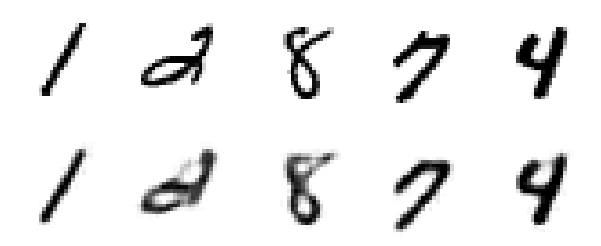

In [15]:
# extra code – shows the reconstructions
plot_reconstructions(conv_ae)
plt.show()

## Visualizing the MNIST Dataset

157/157 [==============================] - 1s 3ms/step


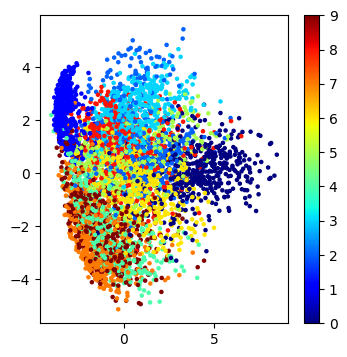

In [66]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

X_valid_pred = conv_ae.predict(X_valid)

X_valid_2D = pca.fit_transform(X_valid_pred.reshape(-1,28*28))
plt.figure(figsize=(4, 4))
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s = 5, cmap='jet')
plt.colorbar()

Let's make this diagram a bit prettier (adapted from [this Scikit-Learn example](https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html)):

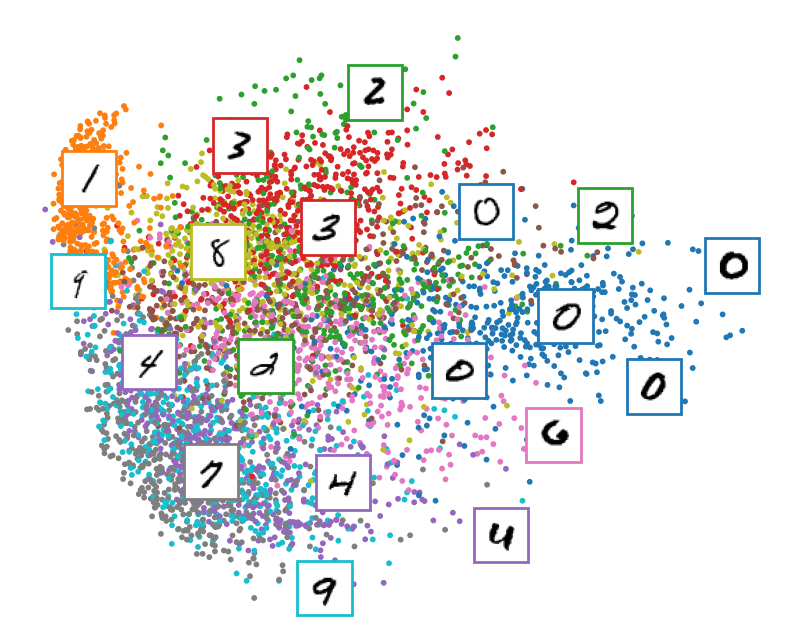

In [23]:
# extra code – beautifies the previous diagram for the book

import matplotlib as mpl

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = X_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min())  # normalize to the 0-1 range
plt.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)

plt.axis("off")
plt.show()

This function processes a few validation images through the autoencoder and displays the original images and their reconstructions:

The reconstructions look fuzzy, but remember that the images were compressed down to just 30 numbers, instead of 784.

# Variational Autoencoder

###Note: we'll use MLP encoder-decoder but a conv2d should be used for images as shown above

In [24]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean 

In [26]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings_size = 10

inputs = tf.keras.layers.Input(shape=[28, 28])
Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(150, activation="relu")(Z)
Z = tf.keras.layers.Dense(100, activation="relu")(Z)
codings_mean = tf.keras.layers.Dense(codings_size)(Z)  # μ
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)  # γ
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [27]:
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(100, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(150, activation="relu")(x)
x = tf.keras.layers.Dense(28 * 28)(x)
outputs = tf.keras.layers.Reshape([28, 28])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [28]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

In [29]:
latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
    axis=-1)
variational_ae.add_loss(tf.reduce_mean(latent_loss) / 784.)

In [31]:
variational_ae.compile(loss="mse", optimizer="nadam")
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 8s 8ms/step - loss: 0.0565 - val_loss: 0.0468
Epoch 2/25
430/430 [==============================] - 3s 7ms/step - loss: 0.0453 - val_loss: 0.0437
Epoch 3/25
430/430 [==============================] - 3s 6ms/step - loss: 0.0434 - val_loss: 0.0424
Epoch 4/25
430/430 [==============================] - 3s 6ms/step - loss: 0.0423 - val_loss: 0.0416
Epoch 5/25
430/430 [==============================] - 3s 6ms/step - loss: 0.0417 - val_loss: 0.0411
Epoch 6/25
430/430 [==============================] - 3s 8ms/step - loss: 0.0412 - val_loss: 0.0406
Epoch 7/25
430/430 [==============================] - 3s 7ms/step - loss: 0.0408 - val_loss: 0.0404
Epoch 8/25
430/430 [==============================] - 3s 6ms/step - loss: 0.0405 - val_loss: 0.0401
Epoch 9/25
430/430 [==============================] - 3s 6ms/step - loss: 0.0403 - val_loss: 0.0399
Epoch 10/25
430/430 [==============================] - 3s 7ms/step - loss: 0.0401 - val_loss: 0.0397

In [32]:
variational_ae.save('/content/gdrive/MyDrive/DL_5783/Materials/Models/variational_ae.keras')
#variational_ae = tf.keras.models.load_model('/content/gdrive/MyDrive/DL_5783/Materials/Models/variational_ae.keras')

1/1 [==============================] - 0s 133ms/step


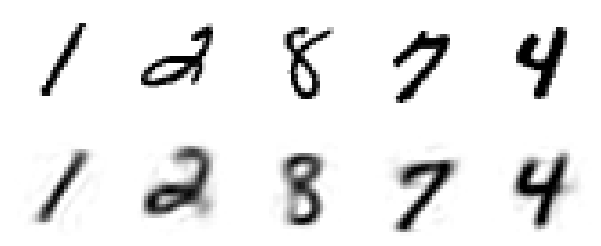

In [33]:
plot_reconstructions(variational_ae)
plt.show()

157/157 [==============================] - 1s 4ms/step


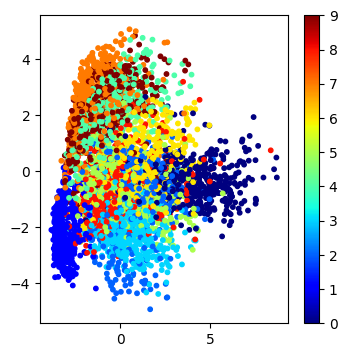

In [34]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

X_valid_pred = variational_ae.predict(X_valid)

X_valid_2D = pca.fit_transform(X_valid_pred.reshape(-1,28*28))
plt.figure(figsize=(4, 4))
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s = 10, cmap='jet')
plt.colorbar()

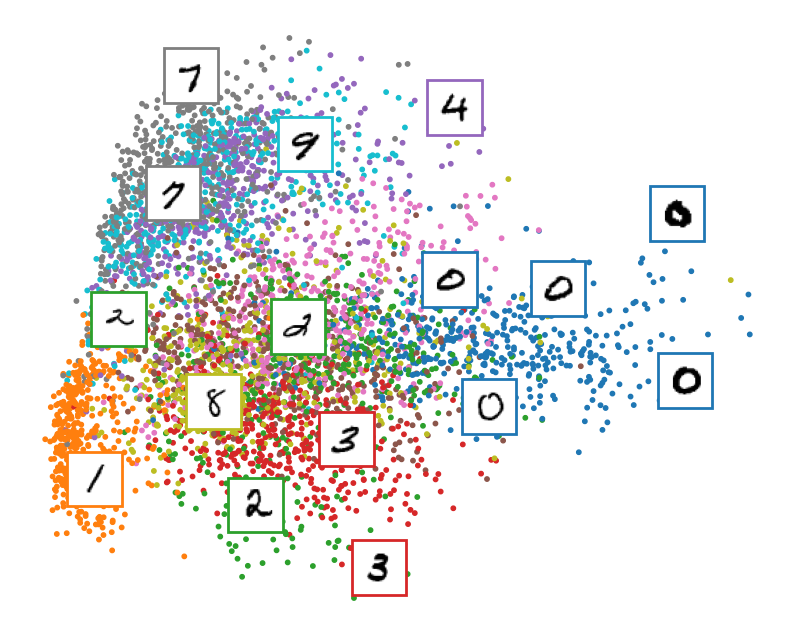

In [35]:
# extra code – beautifies the previous diagram for the book

import matplotlib as mpl

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = X_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min())  # normalize to the 0-1 range
plt.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)

plt.axis("off")
plt.show()

# Conditional Variational Autoencoder

In [36]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings_size = 10
n_class = 10 #10 digits

inputs = tf.keras.layers.Input(shape=[28, 28])

cond_enc = tf.keras.layers.Input(shape=(n_class,), name="cond_enc") # <--- CVAE!

Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(150, activation="relu")(Z)
Z = tf.keras.layers.Dense(100, activation="relu")(Z)

Z = tf.keras.layers.Concatenate(axis=1)([Z, cond_enc]) # <--- CVAE!

codings_mean = tf.keras.layers.Dense(codings_size)(Z)  # μ
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)  # γ
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(
    inputs=[inputs,cond_enc], outputs=[codings_mean, codings_log_var, codings])

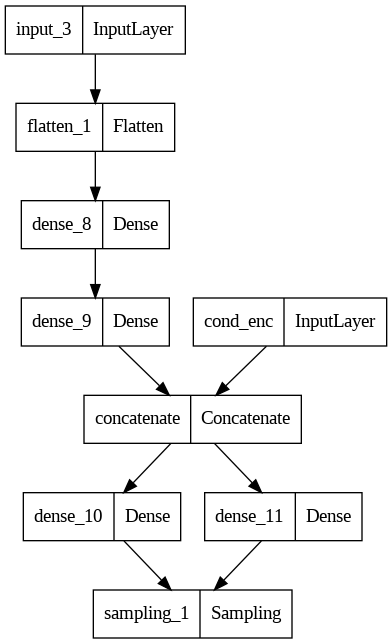

In [37]:
plot_model(variational_encoder)

In [38]:
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])

cond_dec = tf.keras.layers.Input(shape=(n_class,)) # <--- CVAE!
decoder_inputs_cond = tf.keras.layers.Concatenate(axis=1)([decoder_inputs, cond_dec]) # <--- CVAE!

x = tf.keras.layers.Dense(100, activation="relu")(decoder_inputs_cond)
x = tf.keras.layers.Dense(150, activation="relu")(x)
x = tf.keras.layers.Dense(28 * 28)(x)
outputs = tf.keras.layers.Reshape([28, 28])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs,cond_dec], outputs=[outputs])

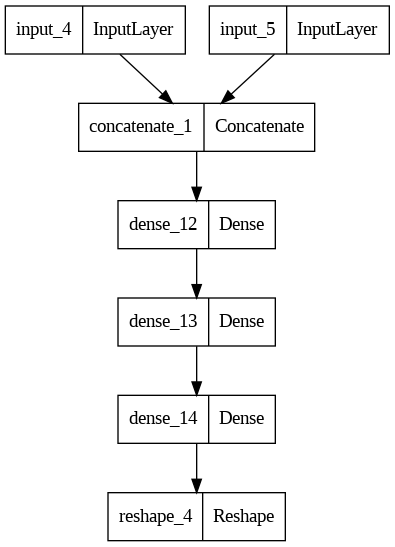

In [39]:
plot_model(variational_decoder)

In [40]:
_, _, codings = variational_encoder([inputs,cond_enc])
reconstructions = variational_decoder([codings,cond_enc])
variational_cae = tf.keras.Model(inputs=[inputs,cond_enc], outputs=[reconstructions])

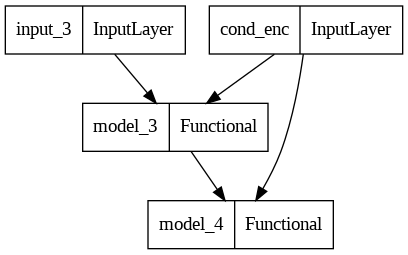

In [41]:
plot_model(variational_cae)

In [42]:
cond_input = np.zeros(shape=(len(y_train),n_class))
cond_valid = np.zeros(shape=(len(y_valid),n_class))

In [43]:
for i,l in enumerate(y_train):
  cond_input[i,l] = 1
for i,l in enumerate(y_valid):
  cond_valid[i,l] = 1

In [44]:
latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
    axis=-1)
variational_cae.add_loss(tf.reduce_mean(latent_loss) / 784.)

In [45]:
variational_cae.compile(loss="mse", optimizer="nadam")
history = variational_cae.fit([X_train,cond_input], X_train, epochs=10, batch_size=128,
                             validation_data=([X_valid,cond_valid], [X_valid]))

Epoch 1/10
430/430 [==============================] - 7s 7ms/step - loss: 0.0531 - val_loss: 0.0433
Epoch 2/10
430/430 [==============================] - 3s 6ms/step - loss: 0.0418 - val_loss: 0.0400
Epoch 3/10
430/430 [==============================] - 4s 8ms/step - loss: 0.0396 - val_loss: 0.0384
Epoch 4/10
430/430 [==============================] - 3s 6ms/step - loss: 0.0384 - val_loss: 0.0374
Epoch 5/10
430/430 [==============================] - 3s 6ms/step - loss: 0.0376 - val_loss: 0.0368
Epoch 6/10
430/430 [==============================] - 3s 7ms/step - loss: 0.0371 - val_loss: 0.0363
Epoch 7/10
430/430 [==============================] - 3s 7ms/step - loss: 0.0366 - val_loss: 0.0360
Epoch 8/10
430/430 [==============================] - 3s 7ms/step - loss: 0.0363 - val_loss: 0.0355
Epoch 9/10
430/430 [==============================] - 3s 7ms/step - loss: 0.0359 - val_loss: 0.0353
Epoch 10/10
430/430 [==============================] - 3s 7ms/step - loss: 0.0357 - val_loss: 0.0351

In [ ]:
variational_cae.save('/content/gdrive/MyDrive/DL_5783/Materials/Models/variational_cae')

In [46]:
variational_cae.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 cond_enc (InputLayer)          [(None, 10)]         0           []                               
                                                                                                  
 model_3 (Functional)           [(None, 10),         135070      ['input_3[0][0]',                
                                 (None, 10),                      'cond_enc[0][0]']               
                                 (None, 10)]                                                      
                                                                                            

In [47]:
def plot_cond_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict([images[:n_images],cond_valid[:n_images]]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

1/1 [==============================] - 0s 136ms/step


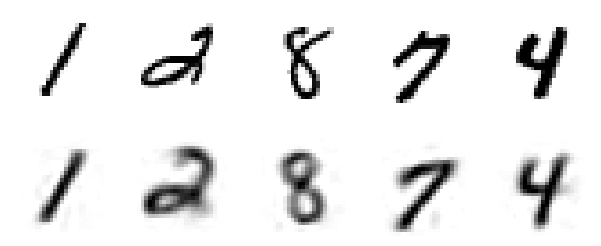

In [48]:
plot_cond_reconstructions(variational_cae)
plt.show()

157/157 [==============================] - 0s 3ms/step


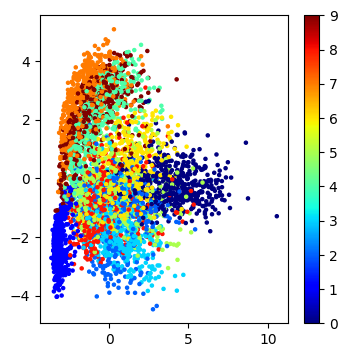

In [51]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

X_valid_pred = variational_cae.predict([X_valid,cond_valid])

X_valid_2D = pca.fit_transform(X_valid_pred.reshape(-1,28*28))
plt.figure(figsize=(4, 4))
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s = 5, cmap='jet')
plt.colorbar()

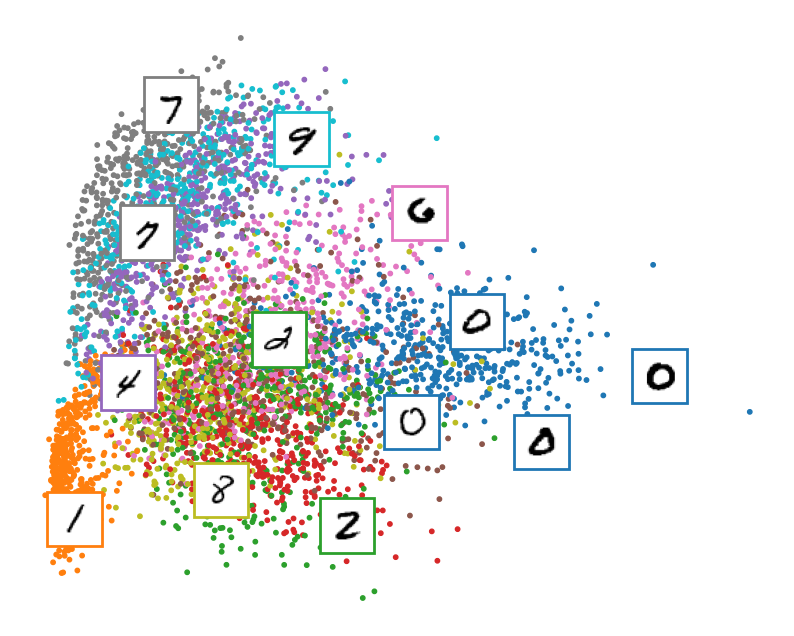

In [52]:
# extra code – beautifies the previous diagram for the book

import matplotlib as mpl

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = X_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min())  # normalize to the 0-1 range
plt.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)

plt.axis("off")
plt.show()

# Conditional Convolutional Variational Autoencoder

In [53]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings_size = 10
n_class = 10 #10 digits

inputs = tf.keras.layers.Input(shape=[28, 28,1])

cond_enc = tf.keras.layers.Input(shape=(n_class,), name="cond_enc") # <--- CVAE!

Z = tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu")(inputs)
Z = tf.keras.layers.MaxPool2D(pool_size=2)(Z)
Z = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu")(Z)
Z = tf.keras.layers.MaxPool2D(pool_size=2)(Z)
Z = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu")(Z)
Z = tf.keras.layers.MaxPool2D(pool_size=2)(Z)
Z = tf.keras.layers.Conv2D(30, 3, padding="same", activation="relu")(Z)
Z = tf.keras.layers.GlobalAvgPool2D()(Z)  # output: 30

Z = tf.keras.layers.Concatenate(axis=1)([Z, cond_enc]) # <--- CVAE!

codings_mean = tf.keras.layers.Dense(codings_size)(Z)  # μ
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)  # γ
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(
    inputs=[inputs,cond_enc], outputs=[codings_mean, codings_log_var, codings])

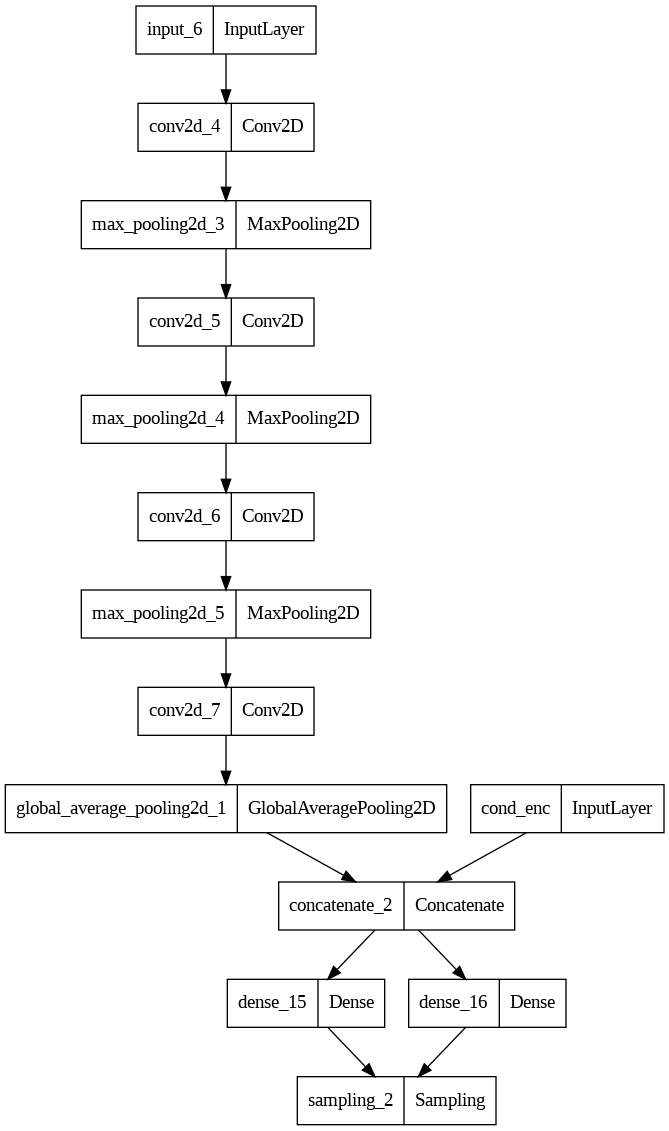

In [54]:
plot_model(variational_encoder)

In [55]:
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])

cond_dec = tf.keras.layers.Input(shape=(n_class,)) # <--- CVAE!
decoder_inputs_cond = tf.keras.layers.Concatenate(axis=1)([decoder_inputs, cond_dec]) # <--- CVAE!

x = tf.keras.layers.Dense(3 * 3 * 16)(decoder_inputs_cond)
x = tf.keras.layers.Reshape((3, 3, 16))(x)
x = tf.keras.layers.Conv2DTranspose(32, 3, strides=2, activation="relu")(x)
x = tf.keras.layers.Conv2DTranspose(16, 3, strides=2, padding="same", activation="relu")(x)
x =  tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding="same")(x)
outputs = tf.keras.layers.Reshape([28, 28])(x)

variational_decoder = tf.keras.Model(inputs=[decoder_inputs,cond_dec], outputs=[outputs])

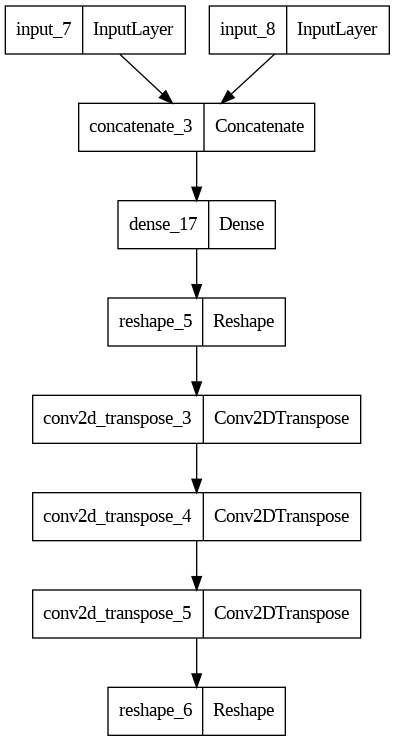

In [56]:
plot_model(variational_decoder)

In [57]:
_, _, codings = variational_encoder([inputs,cond_enc])
reconstructions = variational_decoder([codings,cond_enc])
variational_conv_cae = tf.keras.Model(inputs=[inputs,cond_enc], outputs=[reconstructions])

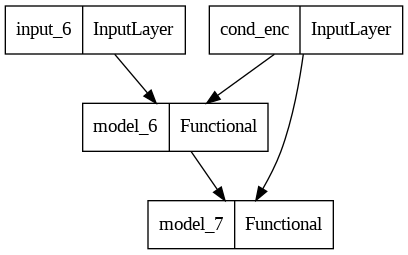

In [58]:
plot_model(variational_conv_cae)

In [60]:
cond_input = np.zeros(shape=(len(y_train),n_class))
cond_valid = np.zeros(shape=(len(y_valid),n_class))

In [61]:
for i,l in enumerate(y_train):
  cond_input[i,l] = 1
for i,l in enumerate(y_valid):
  cond_valid[i,l] = 1

In [62]:
latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
    axis=-1)
variational_conv_cae.add_loss(tf.reduce_mean(latent_loss) / 784.)

In [63]:
variational_conv_cae.compile(loss="mse", optimizer="nadam")
history = variational_conv_cae.fit([X_train,cond_input], X_train, epochs=10, batch_size=128,
                             validation_data=([X_valid,cond_valid], [X_valid]))

Epoch 1/10
430/430 [==============================] - 11s 14ms/step - loss: 0.0484 - val_loss: 0.0421
Epoch 2/10
430/430 [==============================] - 5s 12ms/step - loss: 0.0407 - val_loss: 0.0394
Epoch 3/10
430/430 [==============================] - 5s 11ms/step - loss: 0.0388 - val_loss: 0.0376
Epoch 4/10
430/430 [==============================] - 7s 15ms/step - loss: 0.0376 - val_loss: 0.0369
Epoch 5/10
430/430 [==============================] - 8s 18ms/step - loss: 0.0368 - val_loss: 0.0358
Epoch 6/10
430/430 [==============================] - 9s 20ms/step - loss: 0.0362 - val_loss: 0.0355
Epoch 7/10
430/430 [==============================] - 5s 12ms/step - loss: 0.0358 - val_loss: 0.0354
Epoch 8/10
430/430 [==============================] - 6s 13ms/step - loss: 0.0355 - val_loss: 0.0348
Epoch 9/10
430/430 [==============================] - 5s 12ms/step - loss: 0.0352 - val_loss: 0.0348
Epoch 10/10
430/430 [==============================] - 6s 13ms/step - loss: 0.0350 - val_l

In [ ]:
variational_conv_cae.save('/content/gdrive/MyDrive/DL_5783/Materials/Models/variational_conv_cae')
#variational_conv_cae = tf.keras.models.load_model('/content/gdrive/MyDrive/DL_5783/Materials/Models/variational_conv_cae')

157/157 [==============================] - 1s 4ms/step


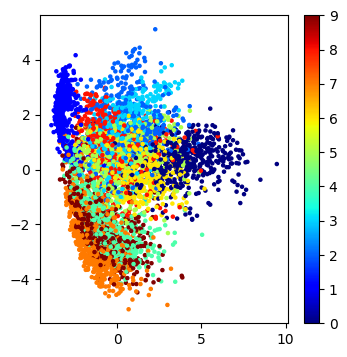

In [64]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

X_valid_pred = variational_conv_cae.predict([X_valid,cond_valid])

X_valid_2D = pca.fit_transform(X_valid_pred.reshape(-1,28*28))
plt.figure(figsize=(4, 4))
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s = 5, cmap='jet')
plt.colorbar()

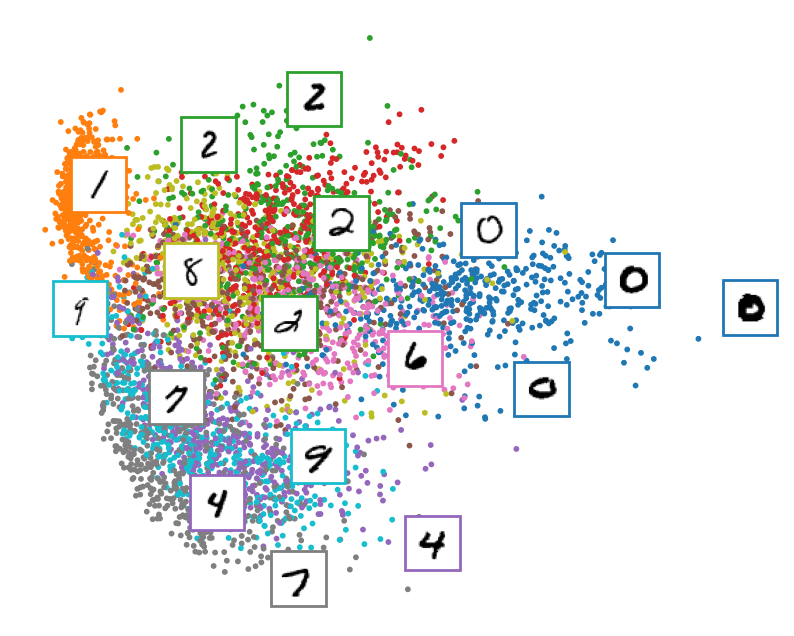

In [65]:
# extra code – beautifies the previous diagram for the book

import matplotlib as mpl

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = X_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min())  # normalize to the 0-1 range
plt.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)

plt.axis("off")
plt.show()

In [77]:
batch = 3
random_codes = tf.keras.backend.random_normal(shape=(batch, codings_size))
#random_codes = np.zeros(shape=(batch, codings_size))
class_ = np.zeros((batch,n_class))
class_[:,9] = 1

In [78]:
g = variational_decoder.predict([random_codes,class_])

1/1 [==============================] - 0s 28ms/step


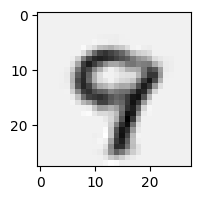

In [79]:
plt.figure(figsize=(2, 2))
plt.imshow(g[0], cmap="binary")

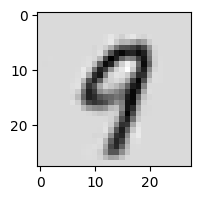

In [80]:
plt.figure(figsize=(2, 2))
plt.imshow(g[1], cmap="binary")

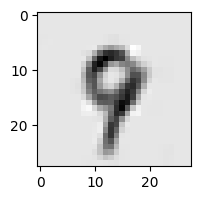

In [81]:
plt.figure(figsize=(2, 2))
plt.imshow(g[2], cmap="binary")

In [82]:
batch = 1
random_codes = tf.keras.backend.random_normal(shape=(batch, codings_size))
#random_codes = np.zeros(shape=(batch, codings_size))
class_ = np.zeros((batch,n_class))
class_[:,8] = 1
g = variational_decoder.predict([random_codes,class_]) 

1/1 [==============================] - 0s 56ms/step


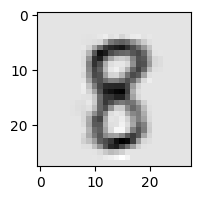

In [83]:
plt.figure(figsize=(2, 2))
plt.imshow(g[0], cmap="binary")

In [84]:
class_ = np.zeros((batch,n_class))
class_[:,7] = 1
g = variational_decoder.predict([random_codes,class_]) 

1/1 [==============================] - 0s 20ms/step


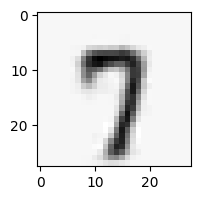

In [85]:
plt.figure(figsize=(2, 2))
plt.imshow(g[0], cmap="binary")

look at:
https://ijdykeman.github.io/ml/2016/12/21/cvae.html